# <center>Eco481 - Project

# <center> Brent Oil - Continuous

## Import libraries

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import datetime

from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder,MinMaxScaler

# Machine learning models
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
# from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Model evaluation
from sklearn.metrics import mean_squared_error

import pickle

## Read Target Dataset - WTI Crude Oil

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/ECO481-Final Project/dataset/Brent Oil Daily.csv')

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
df = df.sort_values(by='Date').reset_index(drop=True)

## Feature Engineering

https://medium.com/analytics-vidhya/stock-trend-prediction-with-technical-indicators-feature-engineering-and-python-code-1fa54d5806ba

### Lagged Price

In [ ]:
df['lag_daily'] = df['Price'].shift(1)
df['lag_weekly'] = df['Price'].shift(5)
df['lag_biweekly'] = df['Price'].shift(10)
df['lag_monthly'] = df['Price'].shift(20)

### Price Difference

In [ ]:
df['diff_daily'] = df['Price'] - df['Price'].shift(1)
df['diff_weekly'] = df['Price'] - df['Price'].shift(5)
df['diff_biweekly'] = df['Price'] - df['Price'].shift(10)
df['diff_monthly'] = df['Price'] - df['Price'].shift(20)

### Returns

In [ ]:
df['return_daily'] = round((df['Price'] - df['Price'].shift(1)) / df['Price'].shift(1) * 100, 2)
df['return_weekly'] = round((df['Price'] - df['Price'].shift(5)) / df['Price'].shift(5) * 100, 2)
df['return_biweekly'] = round((df['Price'] - df['Price'].shift(10)) / df['Price'].shift(10) * 100, 2)
df['return_monthly'] = round((df['Price'] - df['Price'].shift(20)) / df['Price'].shift(20) * 100, 2)

### Simple Moving Average

In [ ]:
df['sma_daily'] = df['Price'].rolling(1).mean()
df['sma_weekly'] = df['Price'].rolling(5).mean()
df['sma_biweekly'] = df['Price'].rolling(10).mean()
df['sma_monthly'] = df['Price'].rolling(20).mean()

### Exponential Weighted Moving Average



In [ ]:
df['ewm_daily'] = df['Price'].ewm(span=1).mean()
df['ewm_weekly'] = df['Price'].ewm(span=5).mean()
df['ewm_biweekly'] = df['Price'].ewm(span=10).mean()
df['ewm_monthly'] = df['Price'].ewm(span=20).mean()

### Average True Range

https://www.investopedia.com/terms/a/atr.asp

In [ ]:
high_low = df['High'] - df['Low']
high_close = np.abs(df['High'] - df['Price'].shift())
low_close = np.abs(df['Low'] - df['Price'].shift())
ranges = pd.concat([high_low, high_close, low_close], axis=1)
true_range = np.max(ranges, axis=1)
df['atr'] = true_range.rolling(14).sum()/14

### Date-related Features

In [ ]:
df['dayofweek'] = df['Date'].dt.dayofweek
df['quarter'] = df['Date'].dt.quarter
df['month'] = df['Date'].dt.month
df['year'] = df['Date'].dt.year
df['dayofyear'] = df['Date'].dt.dayofyear
df['dayofmonth'] = df['Date'].dt.day
df['weekofyear'] = df['Date'].dt.weekofyear

<ipython-input-12-fbfc8ac8aa8a>:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['Date'].dt.weekofyear


In [ ]:
len(df)

2602

In [ ]:
len(df.dropna())

2577

In [ ]:
df
# df.to_excel("/content/gdrive/MyDrive/ECO481-Final Project/dataset updated 2/Feature Engineering dataset.xlsx")

,Date,Price,Open,High,Low,Vol.,Change %,lag_daily,lag_weekly,lag_biweekly,...,ewm_biweekly,ewm_monthly,atr,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
0,2013-02-01,116.76,115.77,117.07,115.40,245.85K,1.05%,NaN,NaN,NaN,...,116.760000,116.760000,NaN,4,1,2,2013,32,1,5
1,2013-02-04,115.60,116.50,116.67,115.32,214.96K,-0.99%,116.76,NaN,NaN,...,116.122000,116.151000,NaN,0,1,2,2013,35,4,6
2,2013-02-05,116.52,115.47,117.23,115.01,227.10K,0.80%,115.60,NaN,NaN,...,116.281993,116.286495,NaN,1,1,2,2013,36,5,6
3,2013-02-06,116.73,116.45,117.05,115.72,207.78K,0.18%,116.52,NaN,NaN,...,116.429592,116.414528,NaN,2,1,2,2013,37,6,6
4,2013-02-07,117.24,116.90,117.83,116.71,242.30K,0.44%,116.73,NaN,NaN,...,116.662238,116.614202,NaN,3,1,2,2013,38,7,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2597,2023-02-22,80.45,82.50,82.96,80.30,297.26K,-3.13%,83.05,85.38,85.09,...,83.562737,83.939627,2.451429,2,1,2,2023,53,22,8
2598,2023-02-23,81.95,80.31,82.46,80.25,293.33K,1.86%,80.45,85.14,84.50,...,83.269512,83.750138,2.282143,3,1,2,2023,54,23,8
2599,2023-02-24,82.82,82.33,83.09,80.75,289.76K,1.06%,81.95,83.00,86.39,...,83.187782,83.661554,2.282857,4,1,2,2023,55,24,8
2600,2023-02-27,82.07,83.05,83.25,81.41,NaN,-0.91%,82.82,84.07,86.61,...,82.984549,83.509977,2.190000,0,1,2,2023,58,27,9


## External Variables

In [ ]:
external_df = pd.read_excel('/content/gdrive/MyDrive/ECO481-Final Project/dataset updated 2/Final Dataset.xlsx',index_col=0)

In [ ]:
external_df['Date']=pd.to_datetime(external_df['Date'])
external_df.set_index('Date')
external_df

,Date,Brent_price,WTI_price,Gold_price,GPR,Sp500,USD_EUR,USD_CAD,TSX,MSCI_index,...,HDD,CDD,Drought Index,Consumer Index,Nature gas price,OPEC Total Crude Oil Production,OPEC Total Crude Oil Production Capacity,Oil Inventory,US GDP,CPI
0,2013-02-01,116.76,97.77,"1,670.60",81.590332,"1,506.75",0.7326,1.003311,12768.799805,"1,072.82",...,738.0,10.0,-4.9,77.6,3.301,29.29,32.56,1039081,99.888699,232.166
1,2013-02-04,115.60,96.17,"1,676.40",81.590332,"1,493.50",0.7399,1.003210,12717.599609,"1,072.73",...,738.0,10.0,-4.9,77.6,3.315,29.29,32.56,1039081,99.888699,232.166
2,2013-02-05,116.52,96.64,"1,673.50",81.590332,"1,506.00",0.7365,1.002305,12745.700195,"1,067.61",...,738.0,10.0,-4.9,77.6,3.399,29.29,32.56,1039081,99.888699,232.166
3,2013-02-06,116.73,96.62,"1,678.80",81.590332,"1,506.75",0.7397,1.004601,12761.599609,"1,063.75",...,738.0,10.0,-4.9,77.6,3.418,29.29,32.56,1039081,99.888699,232.166
4,2013-02-07,117.24,95.83,"1,671.30",81.590332,"1,505.25",0.7464,1.004520,12755.900391,"1,059.56",...,738.0,10.0,-4.9,77.6,3.285,29.29,32.56,1039081,99.888699,232.166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2595,2023-02-22,80.45,73.95,"1,833.30",NaN,"3,999.00",0.9430,0.738831,20193.300781,982.06,...,NaN,NaN,NaN,NaN,2.174,28.42,31.64,850620,NaN,300.840
2596,2023-02-23,81.95,75.39,"1,818.80",NaN,"4,018.75",0.9436,0.738258,20188.199219,987.74,...,NaN,NaN,NaN,NaN,2.314,28.42,31.64,850620,NaN,300.840
2597,2023-02-24,82.82,76.32,"1,809.20",NaN,"3,975.75",0.9479,0.738378,20219.199219,971.87,...,NaN,NaN,NaN,NaN,2.451,28.42,31.64,851786,NaN,300.840
2598,2023-02-27,82.07,75.74,"1,824.00",NaN,"3,988.00",0.9425,0.735635,20260.099609,967.25,...,NaN,NaN,NaN,NaN,2.731,28.42,31.64,851786,NaN,300.840


## Data Preprocessing

### Merge Data

In [ ]:
# join engineered features with external features
# drop useless columns and NaNs
#external_df['Date']=external_df.index
finaldf = pd.merge(df, external_df, on="Date", how="left")
finaldf = finaldf.set_index('Date')
finaldf = finaldf.drop(['Open','High','Low','Vol.','Change %'], axis=1)

### Add in Target Variable


In [ ]:
finaldf['target'] = finaldf['Price'].shift(-5)

In [ ]:
finaldf.drop('Price',inplace=True,axis=1)

In [ ]:
finaldf.drop('Brent_price',inplace=True,axis=1)

In [ ]:
finaldf.dropna(inplace=True)

### Check Data Types

In [ ]:
# check OBJECT data type
finaldf['Gold_price'].dtypes

dtype('O')

In [ ]:
# check OBJECT data type
finaldf['MSCI_index'].dtypes

dtype('O')

In [ ]:
# check OBJECT data type
finaldf['Sp500'].dtypes

dtype('O')

In [ ]:
finaldf['Gold_price'] = finaldf['Gold_price'].apply(lambda x: float(x.replace(',','')))
finaldf['MSCI_index'] = finaldf['MSCI_index'].apply(lambda x: float(x.replace(',','')))
finaldf['Sp500'] = finaldf['Sp500'].apply(lambda x: float(x.replace(',','')))

In [ ]:
finaldf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2422 entries, 2013-03-01 to 2022-11-01
Data columns (total 48 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   lag_daily                                 2422 non-null   float64
 1   lag_weekly                                2422 non-null   float64
 2   lag_biweekly                              2422 non-null   float64
 3   lag_monthly                               2422 non-null   float64
 4   diff_daily                                2422 non-null   float64
 5   diff_weekly                               2422 non-null   float64
 6   diff_biweekly                             2422 non-null   float64
 7   diff_monthly                              2422 non-null   float64
 8   return_daily                              2422 non-null   float64
 9   return_weekly                             2422 non-null   float64
 10  return_biweekly   

### Train test split

In [ ]:
idx = 1695

In [ ]:
# split training and test data based a index
X_train = finaldf.drop(columns = ["target"]).iloc[:idx]
X_test = finaldf.drop(columns = ["target"]).iloc[idx: ]

y_train = finaldf["target"].iloc[:idx]
y_test = finaldf["target"].iloc[idx: ]

In [ ]:
X_train

,lag_daily,lag_weekly,lag_biweekly,lag_monthly,diff_daily,diff_weekly,diff_biweekly,diff_monthly,return_daily,return_weekly,...,HDD,CDD,Drought Index,Consumer Index,Nature gas price,OPEC Total Crude Oil Production,OPEC Total Crude Oil Production Capacity,Oil Inventory,US GDP,CPI
Date,,,,,,,,,,,,,,,,,,,,,
2013-03-01,111.38,114.10,117.66,116.76,-0.98,-3.70,-7.26,-6.36,-0.88,-3.24,...,664.0,10.0,-5.18,78.6,3.456,29.45,32.72,1048812.0,99.887151,232.773
2013-03-04,110.40,114.44,117.38,115.60,-0.31,-4.35,-7.29,-5.51,-0.28,-3.80,...,664.0,10.0,-5.18,78.6,3.529,29.45,32.72,1048812.0,99.887151,232.773
2013-03-05,110.09,112.71,117.52,116.52,1.52,-1.10,-5.91,-4.91,1.38,-0.98,...,664.0,10.0,-5.18,78.6,3.529,29.45,32.72,1048812.0,99.887151,232.773
2013-03-06,111.61,111.87,115.60,116.73,-0.55,-0.81,-4.54,-5.67,-0.49,-0.72,...,664.0,10.0,-5.18,78.6,3.470,29.45,32.72,1048812.0,99.887151,232.773
2013-03-07,111.06,111.38,113.53,117.24,0.09,-0.23,-2.38,-6.09,0.08,-0.21,...,664.0,10.0,-5.18,78.6,3.582,29.45,32.72,1048812.0,99.887151,232.773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-29,63.87,63.39,63.30,61.69,-1.44,-0.96,-0.87,0.74,-2.25,-1.51,...,600.0,13.0,4.35,96.8,2.281,29.00,30.96,1082262.0,100.726688,257.208
2019-12-02,62.43,63.65,62.44,62.13,-1.51,-2.73,-1.52,-1.21,-2.42,-4.29,...,726.0,11.0,4.37,99.3,2.329,28.91,31.45,1082262.0,100.743830,256.974
2019-12-03,60.92,64.27,60.91,62.96,-0.10,-3.45,-0.09,-2.14,-0.16,-5.37,...,726.0,11.0,4.37,99.3,2.441,28.91,31.45,1082262.0,100.743830,256.974


### Scaling

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Model Implementation

### Time Series CV

In [ ]:
ts_cr_val = TimeSeriesSplit()

In [ ]:
def make_predictions(model):
  model.fit(X_train_scaled, y_train)
  print('The Training RMSE is:',mean_squared_error(y_train,model.predict(X_train_scaled),squared=False))
  model_predictions = model.predict(X_test_scaled)
  print('The Test RMSE is:',mean_squared_error(y_test,model_predictions,squared=False))
  return model_predictions, mean_squared_error(y_train,model.predict(X_train_scaled),squared=False),mean_squared_error(y_test,model_predictions,squared=False)

In [ ]:
# create a funtion to draw graphs (Modified)
def plot_comparison(predictions, targets,title):
  dates = X_test.index.date
  plt.figure(figsize=(10,6))
  plt.plot(dates, predictions,color='red',label='Predicted Prices')
  plt.plot(dates, targets.values,color='black',label='Real Prices')
  plt.xlabel('Date')
  plt.ylabel('Price')
  plt.legend()
  plt.title(title)
  plt.show()

### Dummy Regressor

This regressor is used to set up a benchmark or baseline for this regression analysis

In [ ]:
dm_predictions, dm_train_mse, dm_test_mse = make_predictions(DummyRegressor())

The Training RMSE is: 23.05879418842276
The Test RMSE is: 25.17216739023697


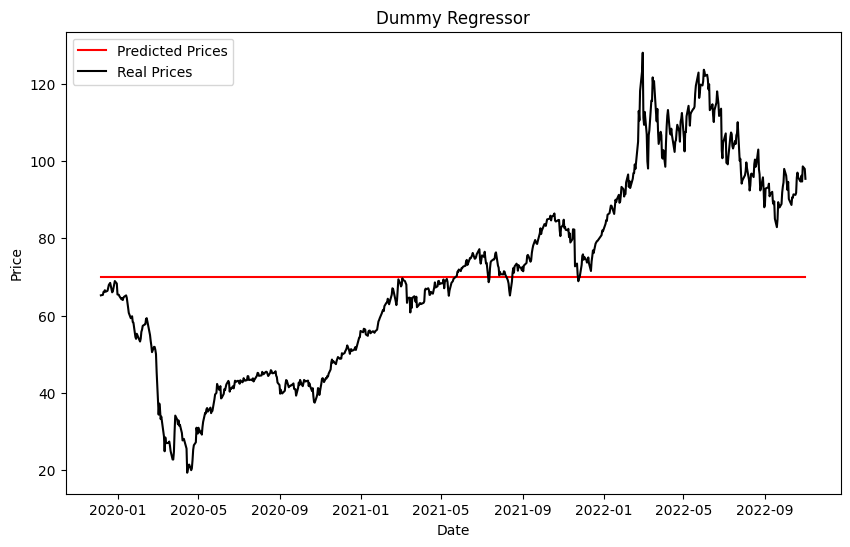

In [ ]:
plot_comparison(dm_predictions,y_test,'Dummy Regressor')

### 1. Linear Regression

In [ ]:
lr_predictions, lr_train_mse, lr_test_mse = make_predictions(LinearRegression())

The Training RMSE is: 2.3326193519005054
The Test RMSE is: 19.81921018576938


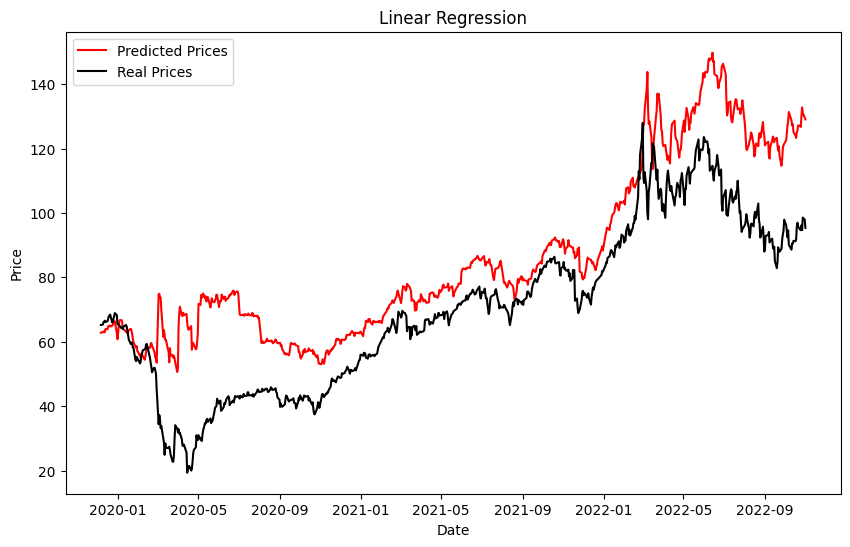

In [ ]:
plot_comparison(lr_predictions,y_test,'Linear Regression')

### 2. KNN

In [ ]:
knn = KNeighborsRegressor()
param_search = {'n_neighbors': [2,3,4,5],
                'weights': ['uniform','distance'],
                'algorithm': ['auto','ball_tree','kd_tree','brute'],
                'p':[1,2]}

knn_gsearch = GridSearchCV(estimator=knn, cv=ts_cr_val, param_grid=param_search,scoring='neg_mean_squared_error',n_jobs=-1)

knn_gsearch.fit(X_train_scaled, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [2, 3, 4, 5], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='neg_mean_squared_error')

In [ ]:
knn_gsearch.best_estimator_

KNeighborsRegressor(n_neighbors=2)

In [ ]:
knn_predictions, knn_train_mse, knn_test_mse = make_predictions(knn_gsearch.best_estimator_)

The Training RMSE is: 0.9068336433090516
The Test RMSE is: 22.514442932112015


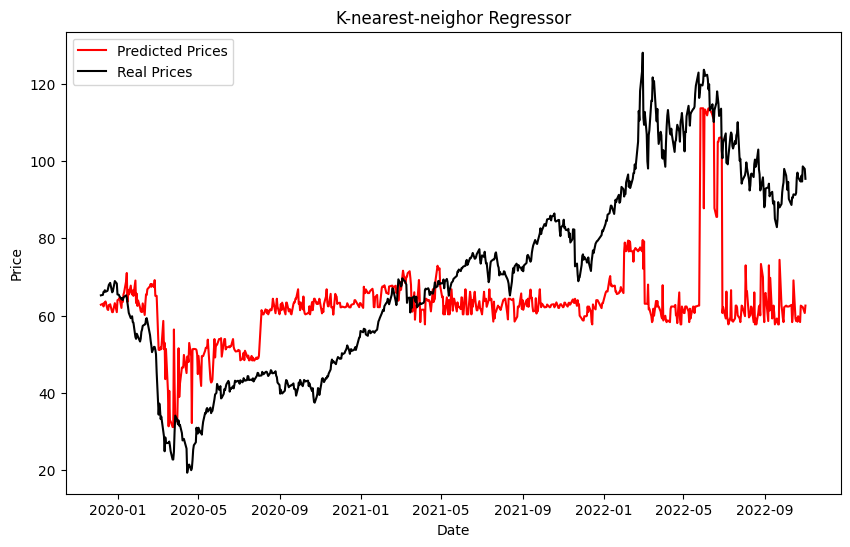

In [ ]:
plot_comparison(knn_predictions, y_test,'K-nearest-neighor Regressor')

### 3. Decision Tree

In [ ]:
dt = DecisionTreeRegressor()
param_search = {"splitter":["best","random"],
                "max_depth" : [1,2,3,5,7],
                "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
                "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5],
                "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90] }
dt_gsearch = GridSearchCV(estimator=dt, cv=ts_cr_val, param_grid=param_search,scoring='neg_mean_squared_error',n_jobs=-1)
dt_gsearch.fit(X_train_scaled, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 5, 7],
                         'max_leaf_nodes': [None, 10, 20, 30, 40, 50, 60, 70,
                                            80, 90],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'min_weight_fraction_leaf': [0.1, 0.2, 0.3, 0.4, 0.5],
                         'splitter': ['best', 'random']},
             scoring='neg_mean_squared_error')

In [ ]:
dt_predictions, dt_train_mse, dt_test_mse = make_predictions(dt_gsearch.best_estimator_)

The Training RMSE is: 4.113539249775138
The Test RMSE is: 7.9370535097936505


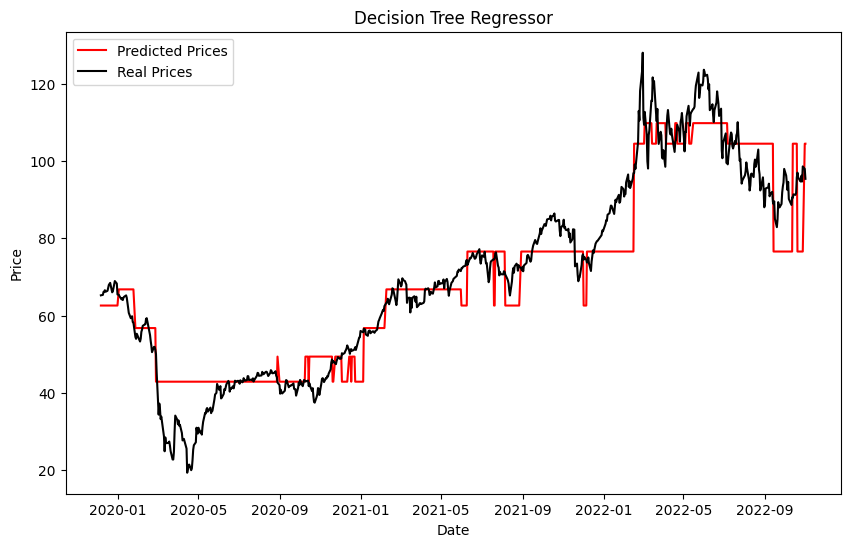

In [ ]:
plot_comparison(dt_predictions, y_test,'Decision Tree Regressor')

### 4. Random Forest

In [ ]:
rf = RandomForestRegressor()
param_search = {'max_depth': [1,2,3],
                'min_samples_leaf': [1,2,4],
                'min_samples_split': [2,5,10],
                'ccp_alpha': [0,0.01,0.1,1,10]}
rf_gsearch = GridSearchCV(estimator=rf, cv=ts_cr_val, param_grid=param_search,scoring='neg_mean_squared_error',n_jobs=-1)
rf_gsearch.fit(X_train_scaled, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'ccp_alpha': [0, 0.01, 0.1, 1, 10],
                         'max_depth': [1, 2, 3], 'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='neg_mean_squared_error')

In [ ]:
rf_gsearch.best_estimator_

RandomForestRegressor(ccp_alpha=1, max_depth=3, min_samples_split=5)

In [ ]:
rf_predictions, rf_train_mse, rf_test_mse = make_predictions(rf_gsearch.best_estimator_)

The Training RMSE is: 3.3707286876605678
The Test RMSE is: 5.956024981252021


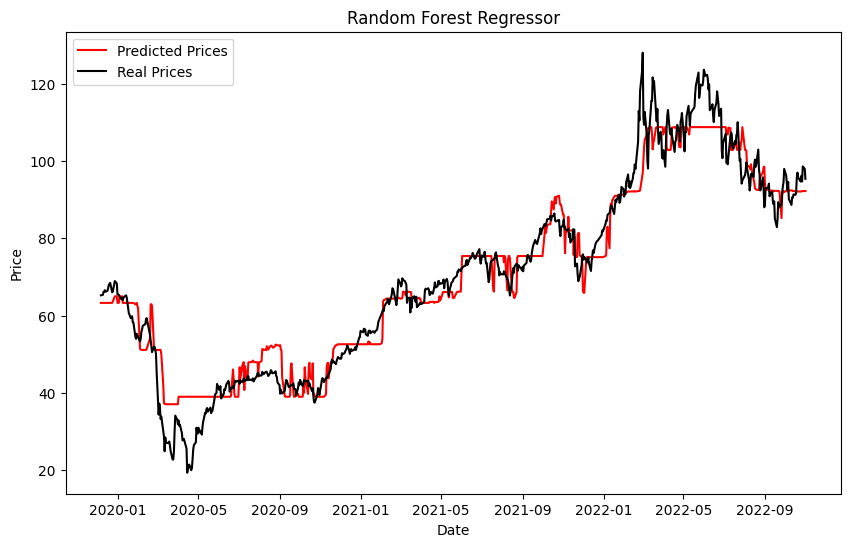

In [ ]:
plot_comparison(rf_predictions, y_test,'Random Forest Regressor')

### 5. Gradient Boosting

In [ ]:
gbt = GradientBoostingRegressor()
param_search = {'learning_rate':[0.001,0.01,0.1],
                'max_depth':[2,4,6,10,20],
                'min_samples_leaf': [1,2,4],
                'min_samples_split': [2,5,10],
                'subsample':[.5,.75,1]}
gbt_gsearch = GridSearchCV(estimator=gbt, cv=ts_cr_val, param_grid=param_search,scoring='neg_mean_squared_error',n_jobs=-1)
gbt_gsearch.fit(X_train_scaled, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': [2, 4, 6, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'subsample': [0.5, 0.75, 1]},
             scoring='neg_mean_squared_error')

In [ ]:
gbt_gsearch.best_estimator_

GradientBoostingRegressor(max_depth=20, min_samples_leaf=2, subsample=1)

In [ ]:
gbt_predictions, gbt_train_mse, gbt_test_mse = make_predictions(gbt_gsearch.best_estimator_)

The Training RMSE is: 0.0022479447854323225
The Test RMSE is: 6.638657772095753


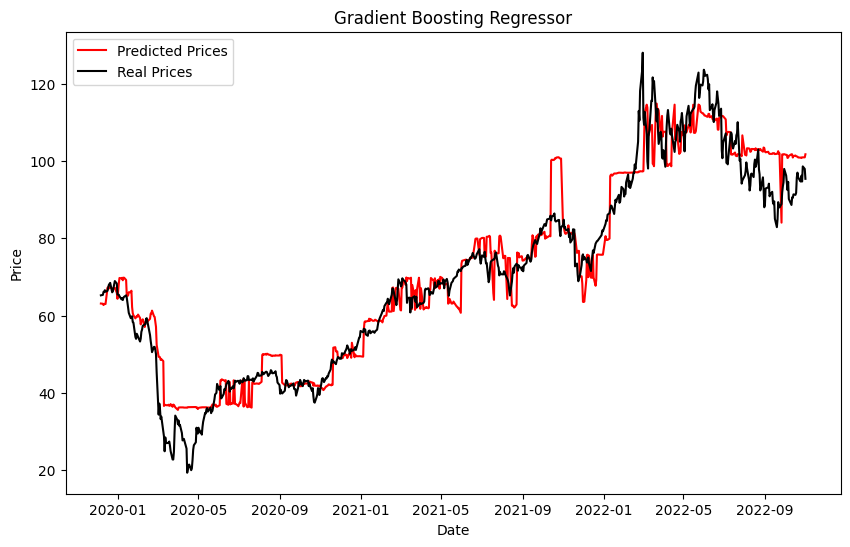

In [ ]:
plot_comparison(gbt_predictions, y_test,'Gradient Boosting Regressor')

In [ ]:
print('Brent Oil Price - Continuous')
pd.DataFrame(
    {
     'Training RMSE':[dm_train_mse,lr_train_mse,knn_train_mse,dt_train_mse,rf_train_mse,gbt_train_mse],
     'Test RMSE':[dm_test_mse,lr_test_mse,knn_test_mse,dt_test_mse,rf_test_mse,gbt_test_mse]
    },
    index = ['Dummy','Linear Regression','K-nearest-neighbors','Decision Tree','Random Forest','Gradient Boosting']
)

Brent Oil Price - Continuous


,Training RMSE,Test RMSE
Dummy,23.058794,25.172167
Linear Regression,2.332619,19.819210
K-nearest-neighbors,0.906834,22.514443
Decision Tree,4.113539,7.937054
Random Forest,3.370729,5.956025
Gradient Boosting,0.002248,6.638658


## Feature Importance

Text(0.5, 0, 'Feature Importance')

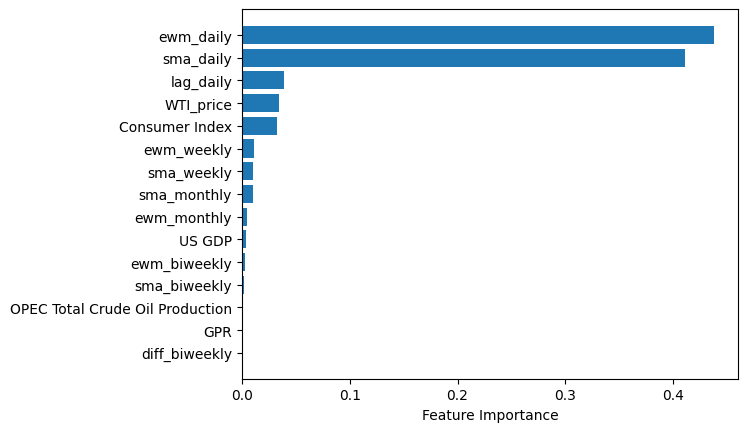

In [ ]:
best_model = rf_gsearch.best_estimator_

best_model.fit(X_train_scaled, y_train)


sort = best_model.feature_importances_.argsort()[-15:]
plt.barh(np.array(X_train.columns)[sort], best_model.feature_importances_[sort])
plt.xlabel("Feature Importance")